In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 35.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 목차

1. 프로젝트 개요  
 1.1. 문제 정의 및 목표  
 1.2. 데이터셋 및 평가 방법 설명  

2. 환경 설정 및 데이터 준비  
 2.1. 환경 설정  
 2.2. 데이터 로드 및 전처리  
 2.3. 데이터셋·라벨 구조 및 길이 분석  

3. 임베딩 기반 텍스트 분류 모델 구현  
 3.1. 데이터셋 클래스 및 데이터 로더 정의  
 3.2. 임베딩 벡터(Word2Vec, FastText, GloVe) 구성  
 3.3. LSTM 기반 분류 모델 구조 정의  
 3.4. 학습 설정 및 모델 학습(임베딩별 실험 포함)  

4. 성능 비교, 추가 실험 및 결론  
 4.1. 모델별 성능 비교 분석  
 4.2. 개선 방안 및 추가 실험 결과  
 4.3. 결론 및 한계점·향후 과제  

## 1. 프로젝트 개요

### 1.1. 문제 정의 및 목표

- 이 프로젝트는 20 Newsgroups 텍스트 데이터셋을 활용하여, 각 뉴스 문서를 20개의 주제 카테고리 중 하나로 자동 분류하는 딥러닝 기반 텍스트 분류 모델을 구현하는 것을 목표로 한다.
​

- Word2Vec, FastText, GloVe와 같은 서로 다른 임베딩 기법을 적용하여 텍스트를 벡터화하고, 이를 LSTM 기반 분류 모델에 입력해 임베딩 방식에 따른 성능 차이를 비교·분석한다.
​

- 학습된 모델에 대해 Accuracy, Precision, Recall, F1-score 등의 지표를 계산하고, 전처리·모델 구조·하이퍼파라미터 관점에서 성능 개선 방안을 탐색한다.

### 1.2. 데이터셋 설명

- 데이터셋: 20 Newsgroups  
\*로컬에 압축 형태로 저장된 20news-bydate-train, 20news-bydate-test 디렉터리 구조 사용​  
[다운로드 링크](https://figshare.com/articles/dataset/20news-bydate_tar_gz/3829962?file=5975967)

- 구성
    - 문서 수: 총 18,846개 뉴스 문서
    - 카테고리 수: 총 20개(정치, 스포츠, 컴퓨터, 종교 등 다양한 주제의 뉴스 그룹)
    - 데이터 형식: 각 파일이 하나의 문서이며, 텍스트 내용과 헤더·푸터·인용문이 포함된 원시 뉴스 기사

- 전처리 방식
    - 원본 뉴스에서 헤더, 푸터, 인용 문장을 제거하여 fetch_20newsgroups(remove=('headers','footers','quotes'))와 유사한 형태로 정리한다.
    - 이후 소문자 변환, 특수문자 제거, 불용어 제거 등의 정제 과정을 거쳐 모델이 학습하기 적합한 텍스트 형태를 만든다.

- 평가 방법
    - 기본적으로 테스트 세트에 대해 분류 정확도(Accuracy)를 계산한다.
    - 필요 시 각 클래스별 Precision, Recall, F1-score를 추가로 측정하여 임베딩 방식 간 성능을 비교한다.

## 2. 환경 설정 및 데이터 준비

### 2.1. 환경 설정

- 텍스트 전처리, 임베딩 학습, 딥러닝 모델 구현을 위해 `gensim`, `torch`, `nltk`, `sklearn`, `matplotlib`, `numpy` 등을 임포트한다.

- NLTK 토크나이저와 불용어 사전을 다운로드하고, GPU 사용 가능 여부에 따라 연산 장치를 설정한다.

In [4]:
from gensim.models import Word2Vec, FastText
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk

# NLTK 리소스 다운로드
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 2.2. 로컬 데이터 로드 및 전처리

- 원래는 fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))로 데이터를 바로 다운로드·전처리하려 했으나, 환경 이슈(403 에러 등)로 인해 이 방식 사용이 어려웠다.

- 따라서 20 Newsgroups 압축 파일을 로컬로 다운로드한 뒤, 디렉터리 구조(20news-bydate-train, 20news-bydate-test)에서 직접 파일을 읽어들이는 방식으로 데이터를 로드한다.

- 이때, strip_newsgroup_header, strip_newsgroup_quoting, strip_newsgroup_footer 함수를 정의하여 헤더/인용/푸터를 제거하고, fetch_20newsgroups(remove=...)와 최대한 비슷한 형태로 텍스트를 정리한다.

In [6]:
# # 압축 파일 드라이브 위치후 최초 1회 실행(런타임 초기화 무관)

# import tarfile
# import os

# tar_path = "/content/drive/MyDrive/data/20news-bydate.tar.gz"

# with tarfile.open(tar_path, "r:gz") as tar:
#     tar.extractall(path=base_path)

In [7]:
import os
import re

base_path = "/content/drive/MyDrive/data/20news-bydate"

def strip_newsgroup_header(text):
    _before, _blankline, after = text.partition("\n\n")
    return after

_QUOTE_RE = re.compile(
    r"(writes in|writes:|wrote:|says:|said:|^In article|^Quoted from|^\||^>)"
)

def strip_newsgroup_quoting(text):
    good_lines = [
        line for line in text.split("\n")
        if not _QUOTE_RE.search(line)
    ]
    return "\n".join(good_lines)

def strip_newsgroup_footer(text):
    lines = text.strip().split("\n")
    for line_num in range(len(lines) - 1, -1, -1):
        line = lines[line_num]
        if line.strip().strip("-") == "":
            break
    if line_num > 0:
        return "\n".join(lines[:line_num])
    else:
        return text

def clean_like_sklearn(text):
    text = strip_newsgroup_header(text)
    text = strip_newsgroup_quoting(text)
    text = strip_newsgroup_footer(text)
    return text

In [8]:
def load_20news_flat(base_path):
    texts = []
    labels = []
    label_map = {}
    label_id = 0

    # train / test 디렉터리 모두 순회
    for split in ["20news-bydate-train", "20news-bydate-test"]:
        split_path = os.path.join(base_path, split)

        for category in sorted(os.listdir(split_path)):
            category_path = os.path.join(split_path, category)
            if not os.path.isdir(category_path):
                continue

            if category not in label_map:
                label_map[category] = label_id
                label_id += 1

            for fname in os.listdir(category_path):
                file_path = os.path.join(category_path, fname)
                try:
                    with open(file_path, encoding="latin1") as f:
                        raw_text = f.read()
                        # fetch_20newsgroups(remove=('headers','footers','quotes'))유사하게 처리
                        text = clean_like_sklearn(raw_text)
                        texts.append(text)
                        labels.append(label_map[category])
                except:
                    pass

    return texts, labels

In [9]:
texts, labels = load_20news_flat(base_path)
print(f"Number of documents: {len(texts)}")
print(f"Sample document: \n{texts[0]}")
print(f"Unique labels: {set(labels)}")

Number of documents: 18846
Sample document: 
Why are only those people in favor of the system to blame.  If society
accepts such a system, then each member of society is to blame when
an innocent person gets executed.  Those that are not in favor should
work to convince others.

And, most members of our society have accepted the blame--they've considered
the risk to be acceptable.  Similarly, every person who drives must accept
the blame for fatal traffic accidents.  This is something that is surely
going to happen when so many people are driving.  It is all a question of
what risk is acceptable.  It is much more likely that an innocent person
will be killed driving than it is that one will be executed.
Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


- 데이터 구성 요약

  | 항목        | 내용                                                                                 |
  | --------- | ---------------------------------------------------------------------------------- |
  | 총 문서 수    | 18,846                                                                             |
  | 카테고리 수    | 20                                                                                 |
  | 학습·테스트 분할 | 디렉터리 기준 train/test 분리 후, 추가로 train/test 8:2 분할 사용 |

- 이후 단계에서 로컬에서 로드한 texts, labels를 기준으로 정규식·불용어 제거 등 추가 전처리를 수행하고, train_test_split으로 학습/테스트 세트를 8:2로 나눈다.

### 2.3. 데이터셋·라벨 구조 및 길이 분석

- 로컬에서 로드한 texts, labels를 학습용·테스트용으로 8:2 비율로 분할한다.

- 이후 전처리 함수(clean_text)를 적용해 소문자 변환, 특수문자 제거, 불용어 제거를 수행하여 모델 학습에 적합한 문장 형태로 만든다.

In [10]:
# 학습/테스트 분할
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [11]:
# 전처리 함수 정의
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# 전처리 적용
train_inputs = [clean_text(text) for text in train_inputs]
test_inputs  = [clean_text(text) for text in test_inputs]

- 전처리된 문장들을 단어 단위로 토큰화한 뒤, 각 문서의 길이(단어 수)를 측정하여 분포를 확인한다.

- 히스토그램과 평균·최대값·95퍼센타일을 이용해, 패딩에 사용할 최대 길이(max_len)를 결정한다.

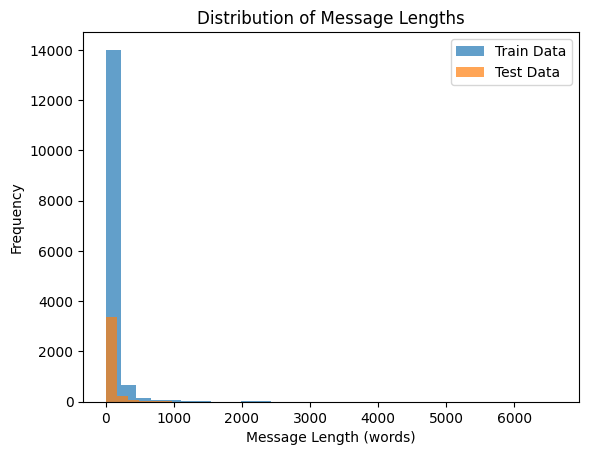

훈련 데이터 평균 길이: 96.30405943221014
훈련 데이터 최대 길이: 6620
훈련 데이터 95분위수 길이: 284.0


In [12]:
train_lengths = [len(word_tokenize(msg)) for msg in train_inputs]
test_lengths  = [len(word_tokenize(msg)) for msg in test_inputs]

plt.hist(train_lengths, bins=30, alpha=0.7, label='Train Data')
plt.hist(test_lengths, bins=30, alpha=0.7, label='Test Data')
plt.xlabel('Message Length (words)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Message Lengths')
plt.show()

print("훈련 데이터 평균 길이:", np.mean(train_lengths))
print("훈련 데이터 최대 길이:", np.max(train_lengths))
print("훈련 데이터 95분위수 길이:", np.percentile(train_lengths, 95))

- 베이스라인에서는 95퍼센타일을 참고하여 max_len ≈ 280 정도로 설정하여, 대부분의 문서를 정보 손실 없이 커버하면서도 너무 긴 문서로 인한 연산 낭비를 줄이도록 했다.

In [17]:
max_len = 280

## 3. 임베딩 기반 텍스트 분류 모델 구현

### 3.1. 데이터셋 클래스 및 데이터 로더 정의
- 목표: LSTM에 바로 넣을 수 있는 형태의 텐서로 바꿔 주는 공통 파이프라인을 만든다.  
\*전처리된 텍스트를 토큰화 → 단어를 정수 인덱스로 변환 → max_len까지 패딩/자르기

- 이 클래스는 임베딩 종류(Word2Vec, FastText, GloVe)에 상관없이 동일하게 재사용하고, 임베딩마다 달라지는 것은 word2idx 사전과 임베딩 행렬뿐이다.

In [13]:
class TextEmbeddingDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len):
        self.texts = texts          # 전처리된 문자열 리스트
        self.labels = labels        # 정수 레이블 리스트
        self.word2idx = word2idx    # 단어 → 인덱스 매핑 (임베딩별로 다름)
        self.max_len = max_len      # 패딩/자르기 기준 길이

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # 1) 문장 토큰화
        tokens = word_tokenize(self.texts[idx])

        # 2) 각 단어를 인덱스로 변환 (사전에 없으면 0으로 처리)
        encoded = [self.word2idx.get(word, 0) for word in tokens]

        # 3) max_len 기준으로 패딩 또는 자르기
        if len(encoded) < self.max_len:
            encoded += [0] * (self.max_len - len(encoded))
        else:
            encoded = encoded[:self.max_len]

        # 4) 텐서로 변환 (입력: long, 레이블: long)
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

- 이후 공통 클래스에 각 임베딩별 사전만 넣어주면 된다.

### 3.2. 임베딩 벡터(Word2Vec, FastText, GloVe) 구성

- 목표: 같은 텍스트 데이터를 세 가지 방식으로 벡터화하여, 임베딩 방식만 다르게 한 상태에서 LSTM 분류 성능을 비교한다.

#### Word2Vec

- 전처리된 train_inputs를 단어 단위로 토큰화해 train_sentences를 만들고, 이를 이용해 Word2Vec을 직접 학습한다.

- 학습된 모델의 단어 목록(wv.index_to_key)을 기준으로 단어→인덱스 매핑(word2idx_word2vec)을 만들고, 해당 크기에 맞는 임베딩 행렬 word2vec_matrix를 구성한다.

In [14]:
# 토큰화
train_sentences = [word_tokenize(text) for text in train_inputs]

# Word2Vec 학습
word2vec_model = Word2Vec(
    sentences=train_sentences,
    vector_size=128,
    window=5,
    min_count=1,
    sg=1
)

# 임베딩 행렬 및 단어 사전
word2vec_matrix = np.zeros((len(word2vec_model.wv) + 1, 128))
word2idx_word2vec = {
    word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)
}

for word, idx in word2idx_word2vec.items():
    word2vec_matrix[idx] = word2vec_model.wv[word]

#### FastText
- 동일한 train_sentences를 사용하되, FastText는 subword 정보를 활용하므로 OOV 단어에 조금 더 강인한 임베딩을 제공할 수 있다.

- Word2Vec과 동일한 방식으로 word2idx_fasttext와 fasttext_matrix를 구성한다.

In [15]:
fasttext_model = FastText(
    sentences=train_sentences,
    vector_size=128,
    window=5,
    min_count=1,
    sg=1
)

fasttext_matrix = np.zeros((len(fasttext_model.wv) + 1, 128))
word2idx_fasttext = {
    word: idx + 1 for idx, word in enumerate(fasttext_model.wv.index_to_key)
}

for word, idx in word2idx_fasttext.items():
    fasttext_matrix[idx] = fasttext_model.wv[word]

#### GloVe
- GloVe는 이미 대규모 말뭉치에서 학습된 사전학습 임베딩을 사용하며, 로컬에 다운로드한 glove.6B.200d.txt를 불러와 glove_embeddings 딕셔너리를 만든다.

- 이 단어 목록으로 word2idx_glove, glove_matrix를 만들고, 없는 단어(OOV)는 0 벡터로 둔다.

In [18]:
import os
import urllib.request

# GloVe 다운로드 및 임베딩 로드
GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "glove.6B.zip"
GLOVE_FILE = "glove.6B.200d.txt"

if not os.path.exists(GLOVE_FILE):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)
    import zipfile
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as zip_ref:
        zip_ref.extractall()
    print("GloVe embeddings downloaded and extracted.")
else:
    print("GloVe embeddings already available.")

GloVe embeddings downloaded and extracted.


In [19]:
embedding_dim = 200
glove_embeddings = {}

with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coeffs

word2idx_glove = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
glove_matrix = np.zeros((len(word2idx_glove) + 1, embedding_dim))

for word, idx in word2idx_glove.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        glove_matrix[idx] = embedding_vector

- 본 프로젝트에서는 동일한 LSTM 기반 분류 모델을 사용한 상태에서, 임베딩 방식(Word2Vec, FastText, GloVe)에 따른 성능 차이를 비교하는 데 초점을 둔다. 이 중 GloVe는 직접 학습 임베딩이 아니라, 대규모 코퍼스에서 사전 학습된 임베딩을 사용하기 때문에 보다 풍부한 일반 어휘 정보를 담고 있어, 뉴스 도메인 텍스트 분류에서 상대적으로 유리할 것으로 가정한다.

### 3.3. LSTM 기반 분류 모델 구조 정의

- 목표: “단어 인덱스 시퀀스 → 임베딩 벡터 시퀀스 → LSTM → 최종 분류 점수” 흐름을 입력 관점에서 명확히 설명한다.

- 입력 흐름 핵심 아이디어:앞에서 만든 임베딩 행렬(Word2Vec, FastText, GloVe 중 하나)을 Embedding 레이어의 가중치로 사용한다.

- TextEmbeddingDataset이 만들어 준 정수 시퀀스(배치 크기 × max_len)를 Embedding 레이어에 넣으면, 각 인덱스가 해당 단어 벡터로 치환된다.

- 이렇게 만들어진 (batch_size, max_len, embedding_dim) 텐서가 LSTM으로 전달되어, 순서 정보를 반영한 문장 표현을 만든다.

In [20]:
import torch.nn as nn
import torch

class EmbeddingLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim,
                 num_layers=2, dropout=0.5):
        super(EmbeddingLSTM, self).__init__()

        # 1) 임베딩 레이어: 사전 준비한 임베딩 행렬을 가중치로 사용
        num_embeddings, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze= True  # 학습 중 임베딩 업데이트 안 함(추가 실험에서 Glove 의 freeze = False 로 두어서 성능 비교 예정)
        )

        # 2) LSTM: 임베딩 벡터 시퀀스를 입력으로 받아 문맥 정보를 학습
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # 3) 출력층: LSTM이 요약한 정보를 이용해 20개 뉴스 카테고리로 분류
        # (양방향이므로 hidden_dim * 2 가 더 자연스럽지만,
        #  베이스라인 구조에 맞춰 hidden_dim만 사용하는 형태도 가능)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, max_len) — 단어 인덱스 시퀀스
        embedded = self.embedding(x)
        # embedded: (batch_size, max_len, embedding_dim)

        # LSTM 통과 (전체 시퀀스 처리)
        _, (hidden, _) = self.lstm(embedded)
        # hidden: (num_layers * num_directions, batch_size, hidden_dim)

        # 마지막 레이어의 hidden state 사용 (문장 요약 벡터)
        out = self.fc(hidden[-1])
        # out: (batch_size, output_dim = 20)
        return out

- 위 구조에서 입력 흐름:
    - Dataset이 만든 인덱스 시퀀스 → Embedding 레이어가 임베딩 행렬에서 해당 행(row)을 찾아 벡터 시퀀스로 변환 → LSTM이 이 벡터 시퀀스를 시간 순서대로 읽으며 hidden state를 쌓음 → 마지막 hidden state를 FC 레이어에 넣어 20개 카테고리 로짓을 출력.

- 임베딩을 바꿀 때는 오직 embedding_matrix만 교체하면 되므로, Word2Vec / FastText / GloVe 모두 동일한 LSTM 구조를 재사용할 수 있다.

### 3.4. 학습 설정 및 모델 학습(임베딩별 실험 포함)

####  공통 학습 설정(공정 비교를 위한 기준)

- 목적: 임베딩만 다르고, 나머지 조건은 모두 동일하게 맞춰 공정 비교를 한다.

- 공통으로 사용하는 설정 예시:
    - 에폭 수: 10
    - 배치 크기: 64 (GloVe만 32처럼 다르게 둘 수도 있지만, 가능하면 통일하는 방향 고려)
    - 옵티마이저: Adam
    - 학습률: 0.005
    - 손실 함수: CrossEntropyLoss

In [21]:
hidden_dim = 128
output_dim = len(set(labels))

loss_fn = nn.CrossEntropyLoss()
lr = 0.005
num_epochs = 10
batch_size = 64

#### 공통 학습·평가 루프 정의

- 동일한 train / evaluate 함수를 정의해, 임베딩 종류만 바꿔가며 재사용한다.

In [22]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)          # (batch_size, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return correct / total

In [23]:
from sklearn.metrics import classification_report

def get_classification_report(model, loader, target_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=target_names))

####  임베딩별 학습 루프 (Word2Vec / FastText / GloVe)
- 각 임베딩에 대해:
    - 공통 TextEmbeddingDataset 클래스를 사용해 임베딩 전용 Dataset·DataLoader를 구성
    - 해당 임베딩 행렬로 EmbeddingLSTM 생성
    - 같은 loss, optimizer, epoch 수로 학습
    - 동일한 evaluate로 테스트 정확도 측정

In [25]:
# Word2Vec Dataset / DataLoader 생성

train_dataset_word2vec = TextEmbeddingDataset(
    texts=train_inputs,
    labels=train_targets,
    word2idx=word2idx_word2vec,
    max_len=max_len
)
test_dataset_word2vec = TextEmbeddingDataset(
    texts=test_inputs,
    labels=test_targets,
    word2idx=word2idx_word2vec,
    max_len=max_len
)

train_loader_word2vec = DataLoader(
    train_dataset_word2vec,
    batch_size=batch_size,
    shuffle=True
)
test_loader_word2vec = DataLoader(
    test_dataset_word2vec,
    batch_size=batch_size,
    shuffle=False
)

In [26]:
# Word2Vec 학습 루프

model_word2vec = EmbeddingLSTM(
    embedding_matrix=word2vec_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model_word2vec.parameters(), lr=lr)

for epoch in range(num_epochs):
    loss = train(model_word2vec, train_loader_word2vec, loss_fn, optimizer)
    print(f"[Word2Vec] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_word2vec = evaluate(model_word2vec, test_loader_word2vec)
print(f"Test Accuracy (Word2Vec + LSTM): {acc_word2vec:.4f}")

[Word2Vec] Epoch 1, Loss: 2.3161
[Word2Vec] Epoch 2, Loss: 1.7203
[Word2Vec] Epoch 3, Loss: 1.3913
[Word2Vec] Epoch 4, Loss: 1.2326
[Word2Vec] Epoch 5, Loss: 1.1466
[Word2Vec] Epoch 6, Loss: 1.0597
[Word2Vec] Epoch 7, Loss: 1.0079
[Word2Vec] Epoch 8, Loss: 0.9514
[Word2Vec] Epoch 9, Loss: 0.9065
[Word2Vec] Epoch 10, Loss: 0.8544
Test Accuracy (Word2Vec + LSTM): 0.6565


In [27]:
# FastText Dataset / DataLoader 생성

train_dataset_fasttext = TextEmbeddingDataset(
    texts=train_inputs,
    labels=train_targets,
    word2idx=word2idx_fasttext,
    max_len=max_len
)
test_dataset_fasttext = TextEmbeddingDataset(
    texts=test_inputs,
    labels=test_targets,
    word2idx=word2idx_fasttext,
    max_len=max_len
)

train_loader_fasttext = DataLoader(
    train_dataset_fasttext,
    batch_size=batch_size,
    shuffle=True
)
test_loader_fasttext = DataLoader(
    test_dataset_fasttext,
    batch_size=batch_size,
    shuffle=False
)

In [28]:
# FastText 학습 루프

model_fasttext = EmbeddingLSTM(
    embedding_matrix=fasttext_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_fasttext = torch.optim.Adam(model_fasttext.parameters(), lr=lr)

for epoch in range(num_epochs):
    loss = train(model_fasttext, train_loader_fasttext, loss_fn, optimizer_fasttext)
    print(f"[FastText] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_fasttext = evaluate(model_fasttext, test_loader_fasttext)
print(f"Test Accuracy (FastText + LSTM): {acc_fasttext:.4f}")

[FastText] Epoch 1, Loss: 2.1476
[FastText] Epoch 2, Loss: 1.6540
[FastText] Epoch 3, Loss: 1.4059
[FastText] Epoch 4, Loss: 1.2406
[FastText] Epoch 5, Loss: 1.1528
[FastText] Epoch 6, Loss: 1.0757
[FastText] Epoch 7, Loss: 1.0201
[FastText] Epoch 8, Loss: 0.9571
[FastText] Epoch 9, Loss: 0.9355
[FastText] Epoch 10, Loss: 0.8754
Test Accuracy (FastText + LSTM): 0.6507


In [29]:
# GloVe Dataset / DataLoader 생성

train_dataset_glove = TextEmbeddingDataset(
    texts=train_inputs,
    labels=train_targets,
    word2idx=word2idx_glove,
    max_len=max_len
)
test_dataset_glove = TextEmbeddingDataset(
    texts=test_inputs,
    labels=test_targets,
    word2idx=word2idx_glove,
    max_len=max_len
)

train_loader_glove = DataLoader(
    train_dataset_glove,
    batch_size=batch_size,
    shuffle=True
)
test_loader_glove = DataLoader(
    test_dataset_glove,
    batch_size=batch_size,
    shuffle=False
)

In [30]:
# GloVe 학습 루프

model_glove = EmbeddingLSTM(
    embedding_matrix=glove_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_glove = torch.optim.Adam(model_glove.parameters(), lr=lr)

for epoch in range(num_epochs):
    loss = train(model_glove, train_loader_glove, loss_fn, optimizer_glove)
    print(f"[GloVe] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_glove = evaluate(model_glove, test_loader_glove)
print(f"Test Accuracy (GloVe + LSTM): {acc_glove:.4f}")

[GloVe] Epoch 1, Loss: 1.8996
[GloVe] Epoch 2, Loss: 1.3281
[GloVe] Epoch 3, Loss: 1.0882
[GloVe] Epoch 4, Loss: 0.8959
[GloVe] Epoch 5, Loss: 0.7689
[GloVe] Epoch 6, Loss: 0.6662
[GloVe] Epoch 7, Loss: 0.5663
[GloVe] Epoch 8, Loss: 0.5393
[GloVe] Epoch 9, Loss: 0.4619
[GloVe] Epoch 10, Loss: 0.4193
Test Accuracy (GloVe + LSTM): 0.6854


In [31]:
print("Word2Vec classification report")
get_classification_report(model_word2vec, test_loader_word2vec)

print("FastText classification report")
get_classification_report(model_fasttext, test_loader_fasttext)

print("GloVe classification report")
get_classification_report(model_glove, test_loader_glove)

Word2Vec classification report
              precision    recall  f1-score   support

           0       0.52      0.35      0.42       160
           1       0.46      0.53      0.49       170
           2       0.58      0.66      0.62       207
           3       0.64      0.44      0.52       203
           4       0.65      0.56      0.60       182
           5       0.74      0.83      0.78       211
           6       0.70      0.79      0.74       202
           7       0.74      0.67      0.70       204
           8       0.74      0.59      0.66       190
           9       0.53      0.87      0.66       195
          10       0.87      0.68      0.77       201
          11       0.80      0.75      0.78       189
          12       0.58      0.57      0.57       206
          13       0.85      0.80      0.83       219
          14       0.65      0.82      0.72       208
          15       0.58      0.86      0.69       183
          16       0.71      0.65      0.68       

## 4. 성능 비교, 추가 실험 및 결론

### 4.1. 모델별 성능 비교 분석

- 동일한 LSTM 구조와 학습 설정(에폭 10, lr 0.005, batch 64, 임베딩 freeze)에서, 임베딩 방식만 Word2Vec / FastText / GloVe로 달리하여 성능을 비교했다.

- Accuracy와 F1-macro, F1-weighted를 기준으로 볼 때, GloVe 임베딩을 사용한 모델이 전반적으로 가장 높은 성능을 보였으며, Word2Vec과 FastText는 서로 비슷한 수준에서 약간의 차이만을 보였다.

  | 지표          | Word2Vec | FastText | GloVe  |
  | ----------- | -------- | -------- | ------ |
  | Accuracy    | 0.6565   | 0.6507   | 0.6854 |
  | F1-macro    | 0.63     | 0.63     | 0.67   |
  | F1-weighted | 0.65     | 0.64     | 0.68   |

- Accuracy 기준으로 GloVe(+LSTM)가 약 0.69로 가장 높고, Word2Vec(약 0.66), FastText(약 0.65)가 그 뒤를 따른다.

- F1-macro 역시 GloVe가 가장 높아, 전체 20개 클래스 전반에서 보다 균형 잡힌 분류 성능을 보였음을 시사한다.

- 일부 클래스(예: label 19 등)에서 공통적으로 낮은 F1을 보이므로, 특정 소수 클래스에 대한 오분류가 성능 한계로 작용하고 있다.

### 4.2. 개선 방안 및 추가 실험 결과

#### 개선 실험 설계  
- 이번 기본 실험 결과, 세 임베딩 모두 에폭 10에서 여전히 loss가 감소하는 추세였고, GloVe + LSTM 조합이 가장 높은 성능(Accuracy 약 0.685, F1-macro 약 0.67)을 보였다. 이를 기반으로, 다음과 같이 단계적으로 성능 향상을 시도하고자 한다.

</br>

- **[추가 실험 1] 에폭 15까지 학습(세 임베딩 공통, freeze 그대로)**

    - 목적: 현재 10에폭에서 수렴이 끝나지 않은 것으로 보이므로, 추가 학습을 통해 각 임베딩의 최대 잠재 성능을 공정하게 비교한다.

    - 설정: Word2Vec / FastText / GloVe 모두, 동일한 학습률(0.005), 배치 크기(64), 손실 함수(CrossEntropyLoss), 임베딩 freeze=True를 유지한 채 에폭 수만 10 → 15로 증가.

    - 기대 효과:  
        - GloVe의 성능이 추가 상승하거나, Word2Vec·FastText의 성능이 GloVe에 더 근접하는지 확인.  
        - “에폭 수 부족”이 현재 성능 차이의 주요 원인인지 평가.

</br>

- **[추가 실험 2] GloVe 임베딩 파인튜닝(freeze=False, 에폭 15)**

    - 목적: 사전학습 GloVe 임베딩을 20 Newsgroups 도메인에 맞게 미세 조정(fine-tuning) 했을 때의 성능 변화를 확인한다.

    - 설정: GloVe 임베딩 행렬을 사용하되, EmbeddingLSTM과 동일 구조에서 임베딩 레이어만 freeze=False로 둔 모델을 별도로 정의한다.

    - 학습 조건(에폭 15, lr 0.005, batch 64)은 1)과 동일하게 유지.

    - 비교 기준: GloVe + ```freeze =True``` + 15 epoch vs GloVe + ```freeze = False``` + 15 epoch

    - Accuracy, F1-macro, F1-weighted를 중심으로, 파인튜닝이 실제로 이득을 주는지 확인.

</br>

- **[추가 실험 3] 추가 실험 1 에서 유의미한 향상이 있을 경우: max_len 조정(280 → 350)**

    - 전제: 실험에서 세 임베딩 모두 에폭 15 기준 성능이 10에폭보다 전반적으로 개선되었다고 판단될 때 진행

    - 목적: 긴 문서의 뒤쪽 정보를 더 많이 활용해, 특히 길이가 긴 카테고리(정치/종교 등)에서의 분류 성능을 개선한다.

    - 설정:
        - 길이 분석 결과와 현재 max_len=280를 기준으로, max_len을 350 로 증가
        - Word2Vec / FastText / GloVe 모두에 대해 “에폭 15 + ```max_len=350```” 설정으로 다시 학습

    - 비교 기준:
        - (에폭 15, max_len=280) vs (에폭 15, max_len=350)
        - Accuracy/F1 관점에서, 추가로 보는 토큰이 실제로 도움을 주는지, 또는 연산량만 늘어나고 성능 이득은 거의 없는지 평가.

**추가실험 1**

In [32]:
#epochs 수 변경(10 → 15)
num_epochs = 15

In [33]:
# Word2Vec 학습 루프

model_word2vec = EmbeddingLSTM(
    embedding_matrix=word2vec_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model_word2vec.parameters(), lr=lr)

for epoch in range(num_epochs):
    loss = train(model_word2vec, train_loader_word2vec, loss_fn, optimizer)
    print(f"[Word2Vec] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_word2vec = evaluate(model_word2vec, test_loader_word2vec)
print(f"Test Accuracy (Word2Vec + LSTM): {acc_word2vec:.4f}")

[Word2Vec] Epoch 1, Loss: 2.3034
[Word2Vec] Epoch 2, Loss: 1.7849
[Word2Vec] Epoch 3, Loss: 1.4472
[Word2Vec] Epoch 4, Loss: 1.2754
[Word2Vec] Epoch 5, Loss: 1.1658
[Word2Vec] Epoch 6, Loss: 1.0961
[Word2Vec] Epoch 7, Loss: 1.0341
[Word2Vec] Epoch 8, Loss: 0.9776
[Word2Vec] Epoch 9, Loss: 0.9302
[Word2Vec] Epoch 10, Loss: 0.8885
[Word2Vec] Epoch 11, Loss: 0.8364
[Word2Vec] Epoch 12, Loss: 0.7891
[Word2Vec] Epoch 13, Loss: 0.7561
[Word2Vec] Epoch 14, Loss: 0.7198
[Word2Vec] Epoch 15, Loss: 0.6770
Test Accuracy (Word2Vec + LSTM): 0.6615


In [34]:
# FastText 학습 루프

model_fasttext = EmbeddingLSTM(
    embedding_matrix=fasttext_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_fasttext = torch.optim.Adam(model_fasttext.parameters(), lr=lr)

for epoch in range(num_epochs):
    loss = train(model_fasttext, train_loader_fasttext, loss_fn, optimizer_fasttext)
    print(f"[FastText] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_fasttext = evaluate(model_fasttext, test_loader_fasttext)
print(f"Test Accuracy (FastText + LSTM): {acc_fasttext:.4f}")

[FastText] Epoch 1, Loss: 2.1173
[FastText] Epoch 2, Loss: 1.6073
[FastText] Epoch 3, Loss: 1.3330
[FastText] Epoch 4, Loss: 1.2347
[FastText] Epoch 5, Loss: 1.1147
[FastText] Epoch 6, Loss: 1.0470
[FastText] Epoch 7, Loss: 0.9709
[FastText] Epoch 8, Loss: 0.9329
[FastText] Epoch 9, Loss: 0.8678
[FastText] Epoch 10, Loss: 0.8214
[FastText] Epoch 11, Loss: 0.7734
[FastText] Epoch 12, Loss: 0.7661
[FastText] Epoch 13, Loss: 0.6996
[FastText] Epoch 14, Loss: 0.8342
[FastText] Epoch 15, Loss: 0.7697
Test Accuracy (FastText + LSTM): 0.6477


In [35]:
# GloVe 학습 루프

model_glove = EmbeddingLSTM(
    embedding_matrix=glove_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_glove = torch.optim.Adam(model_glove.parameters(), lr=lr)

for epoch in range(num_epochs):
    loss = train(model_glove, train_loader_glove, loss_fn, optimizer_glove)
    print(f"[GloVe] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_glove = evaluate(model_glove, test_loader_glove)
print(f"Test Accuracy (GloVe + LSTM): {acc_glove:.4f}")

[GloVe] Epoch 1, Loss: 1.9329
[GloVe] Epoch 2, Loss: 1.3435
[GloVe] Epoch 3, Loss: 1.0970
[GloVe] Epoch 4, Loss: 0.9411
[GloVe] Epoch 5, Loss: 0.7985
[GloVe] Epoch 6, Loss: 0.6686
[GloVe] Epoch 7, Loss: 0.5839
[GloVe] Epoch 8, Loss: 0.5170
[GloVe] Epoch 9, Loss: 0.4405
[GloVe] Epoch 10, Loss: 0.3968
[GloVe] Epoch 11, Loss: 0.3320
[GloVe] Epoch 12, Loss: 0.2993
[GloVe] Epoch 13, Loss: 0.3081
[GloVe] Epoch 14, Loss: 0.2769
[GloVe] Epoch 15, Loss: 0.2268
Test Accuracy (GloVe + LSTM): 0.6775


In [36]:
print("Word2Vec classification report(epochs 15)")
get_classification_report(model_word2vec, test_loader_word2vec)

print("FastText classification report(epochs 15)")
get_classification_report(model_fasttext, test_loader_fasttext)

print("GloVe classification report(epochs 15)")
get_classification_report(model_glove, test_loader_glove)

Word2Vec classification report(epochs 15)
              precision    recall  f1-score   support

           0       0.43      0.52      0.47       160
           1       0.53      0.49      0.51       170
           2       0.55      0.62      0.58       207
           3       0.55      0.67      0.60       203
           4       0.63      0.50      0.56       182
           5       0.79      0.79      0.79       211
           6       0.66      0.79      0.72       202
           7       0.77      0.67      0.72       204
           8       0.72      0.66      0.69       190
           9       0.74      0.74      0.74       195
          10       0.76      0.83      0.80       201
          11       0.73      0.79      0.76       189
          12       0.72      0.46      0.56       206
          13       0.88      0.77      0.82       219
          14       0.74      0.84      0.79       208
          15       0.64      0.78      0.70       183
          16       0.59      0.63      

**추가실험 1 실행 결과**

  | 지표          | Word2Vec | FastText | GloVe  |
  | ----------- | -------- | -------- | ------ |
  | Accuracy    | 0.6565   | 0.6507   | 0.6854 |
  | F1-macro    | 0.63     | 0.63     | 0.67   |
  | F1-weighted | 0.65     | 0.64     | 0.68   |

| 지표          | Word2Vec (10) | Word2Vec (15) | FastText (10) | FastText (15) | GloVe (10) | GloVe (15) |
| ----------- | ------------- | ------------- | ------------- | ------------- | ---------- | ---------- |
| Accuracy    | 0.6565        | 0.6615        | 0.6507        | 0.6477        | 0.6854     | 0.6775     |
| F1-macro    | 0.63          | 0.64          | 0.63          | 0.63          | 0.67       | 0.66       |
| F1-weighted | 0.65          | 0.66          | 0.64          | 0.64          | 0.68       | 0.68       |

- Word2Vec
    - Accuracy: 0.6565 → 0.6615 (소폭 상승)
    - F1-macro: 0.63 → 0.64, F1-weighted: 0.65 → 0.66
    - 전반적으로 약간의 성능 향상이 있었고, 특히 몇몇 클래스에서 recall·precision이 더 균형 있게 개선되었다.

- FastText
    - Accuracy: 0.6507 → 0.6477 (거의 변화 없음, 약간 하락)
    - F1-macro/weighted도 0.63 전후로 큰 변화 없이 유지.
    - 일부 클래스에서 변동이 있지만 전체 성능은 사실상 비슷한 수준으로 머무름.

- GloVe
    - Accuracy: 0.6854 → 0.6775 (소폭 하락)
    - F1-macro: 0.67 → 0.66, F1-weighted: 0.68 → 0.68 (거의 비슷, 약간의 변동)
    - 에폭을 늘렸을 때 train loss는 계속 감소했지만, 테스트 성능은 10 에폭 근처가 가장 좋았던 것으로 보이며, 이후 약간의 과적합 경향이 나타난 것으로 해석할 수 있다.

- 해석
    - Word2Vec는 에폭 15에서 약간의 추가 이득을 보았지만, 상승 폭이 크지는 않다.

    - FastText는 사실상 정체 상태로, 에폭 10 이후 추가 학습이 큰 의미를 주지 못한 상황이다.

    - GloVe는 이미 10 에폭 근처에서 가장 좋은 테스트 성능을 달성했고, 이후 더 학습하면서 약간의 과적합이 생긴 것으로 보인다.

    - 결론적으로, 에폭 10–15 구간에서 극적인 성능 향상은 없고, GloVe(10 에폭 기준)가 여전히 전체적으로 가장 안정적이고 우수한 성능을 보인다.

    - 따라서 **max_len 변경 실험은 에폭 10 기준**으로 하는 것이 합리적이다.

**추가실험 2**

In [37]:
# GloVe 전용 파인튜닝용 클래스를 하나 더 만듭니다. (freeze = False만 다른 버전)

class EmbeddingLSTMFinetune(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim,
                 num_layers=2, dropout=0.5):
        super(EmbeddingLSTMFinetune, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze=False  # 파인튜닝: 임베딩까지 업데이트
        )

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

In [38]:
# GloVe + freeze = False 학습 (epoch 15 기준)

model_glove_ft = EmbeddingLSTMFinetune(
    embedding_matrix=glove_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_glove_ft = torch.optim.Adam(model_glove_ft.parameters(), lr=lr)

for epoch in range(num_epochs):  # num_epochs=15
    loss = train(model_glove_ft, train_loader_glove, loss_fn, optimizer_glove_ft)
    print(f"[GloVe-Finetune] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_glove_ft = evaluate(model_glove_ft, test_loader_glove)
print(f"Test Accuracy (GloVe + LSTM, freeze=False): {acc_glove_ft:.4f}")

print("GloVe-Finetune classification report")
get_classification_report(model_glove_ft, test_loader_glove)

[GloVe-Finetune] Epoch 1, Loss: 1.8144
[GloVe-Finetune] Epoch 2, Loss: 1.0231
[GloVe-Finetune] Epoch 3, Loss: 0.6420
[GloVe-Finetune] Epoch 4, Loss: 0.4233
[GloVe-Finetune] Epoch 5, Loss: 0.2861
[GloVe-Finetune] Epoch 6, Loss: 0.2067
[GloVe-Finetune] Epoch 7, Loss: 0.1378
[GloVe-Finetune] Epoch 8, Loss: 0.0941
[GloVe-Finetune] Epoch 9, Loss: 0.0737
[GloVe-Finetune] Epoch 10, Loss: 0.0719
[GloVe-Finetune] Epoch 11, Loss: 0.0593
[GloVe-Finetune] Epoch 12, Loss: 0.0548
[GloVe-Finetune] Epoch 13, Loss: 0.0651
[GloVe-Finetune] Epoch 14, Loss: 0.0523
[GloVe-Finetune] Epoch 15, Loss: 0.0721
Test Accuracy (GloVe + LSTM, freeze=False): 0.6822
GloVe-Finetune classification report
              precision    recall  f1-score   support

           0       0.52      0.49      0.51       160
           1       0.48      0.63      0.55       170
           2       0.60      0.64      0.62       207
           3       0.64      0.56      0.60       203
           4       0.58      0.75      0.66       

**추가 실험 2 실행 결과**

| 모델                     | Epoch | freeze | Accuracy | F1-macro | F1-weighted |
| ---------------------- | ----- | ------ | -------- | -------- | ----------- |
| GloVe 기본               | 10    | True   | 0.6854   | 0.67     | 0.68        |
| GloVe (추가실험1)          | 15    | True   | 0.6775   | 0.66     | 0.68        |
| GloVe-Finetune (추가실험2) | 15    | False  | 0.6822   | 0.68     | 0.69        |

</br>

- 해석
    - 단순히 에폭만 15로 늘리고 freeze=True를 유지했을 때는, 기본 10에폭보다 오히려 테스트 Accuracy가 약간 떨어져 과적합 경향을 보였다.

    - 반면, 같은 15에폭에서 freeze=False로 파인튜닝한 모델은 Accuracy는 10에폭 기본 GloVe(0.6854)와 거의 비슷한 수준(0.6822), F1-macro/weighted는 오히려 약간 더 높은 값을 보여, 클래스 전반의 균형 측면에서는 소폭 개선이 있었다고 볼 수 있다.

    - 특히 macro avg가 0.68로 가장 높아진 점을 보면, 파인튜닝이 일부 클래스에서 recall/precision 균형을 조금 더 맞춰주는 효과를 낸 것으로 해석할 수 있다.

- 정리:
    - GloVe + freeze=True, epoch 10: 여전히 가장 간단하면서도 강력한 “기본 베이스라인”

    - GloVe + freeze=False, epoch 15: Accuracy는 거의 비슷하지만, macro/weighted F1 기준으로는 약간 더 나은 “강화 버전” 후보

**추가실험 3**

In [39]:
# max_len 280 → 350로 변경
max_len = 350

#epochs 수 변경(15 → 10) *추가 실험 1 결과, epochs 15 에서 유의미한 변화 없으므로 10으로 진행
num_epochs = 10

In [40]:
# max_len=350 버전 Word2Vec Dataset / DataLoader

train_dataset_word2vec_350 = TextEmbeddingDataset(
    texts=train_inputs,
    labels=train_targets,
    word2idx=word2idx_word2vec,
    max_len=max_len  # 350
)
test_dataset_word2vec_350 = TextEmbeddingDataset(
    texts=test_inputs,
    labels=test_targets,
    word2idx=word2idx_word2vec,
    max_len=max_len
)

train_loader_word2vec_350 = DataLoader(
    train_dataset_word2vec_350,
    batch_size=batch_size,
    shuffle=True
)
test_loader_word2vec_350 = DataLoader(
    test_dataset_word2vec_350,
    batch_size=batch_size,
    shuffle=False
)

# FastText max_len=350
train_dataset_fasttext_350 = TextEmbeddingDataset(
    train_inputs, train_targets, word2idx_fasttext, max_len
)
test_dataset_fasttext_350 = TextEmbeddingDataset(
    test_inputs, test_targets, word2idx_fasttext, max_len
)

train_loader_fasttext_350 = DataLoader(train_dataset_fasttext_350, batch_size=batch_size, shuffle=True)
test_loader_fasttext_350 = DataLoader(test_dataset_fasttext_350, batch_size=batch_size, shuffle=False)

# GloVe max_len=350
train_dataset_glove_350 = TextEmbeddingDataset(
    train_inputs, train_targets, word2idx_glove, max_len
)
test_dataset_glove_350 = TextEmbeddingDataset(
    test_inputs, test_targets, word2idx_glove, max_len
)

train_loader_glove_350 = DataLoader(train_dataset_glove_350, batch_size=batch_size, shuffle=True)
test_loader_glove_350 = DataLoader(test_dataset_glove_350, batch_size=batch_size, shuffle=False)

In [41]:
# Word2Vec + max_len=350, epoch=10
model_word2vec_350 = EmbeddingLSTM(
    embedding_matrix=word2vec_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_w2v_350 = torch.optim.Adam(model_word2vec_350.parameters(), lr=lr)

for epoch in range(num_epochs):  # num_epochs = 10
    loss = train(model_word2vec_350, train_loader_word2vec_350, loss_fn, optimizer_w2v_350)
    print(f"[Word2Vec-350] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_word2vec_350 = evaluate(model_word2vec_350, test_loader_word2vec_350)
print(f"Test Accuracy (Word2Vec + LSTM, max_len=350): {acc_word2vec_350:.4f}")

print("Word2Vec-350 classification report")
get_classification_report(model_word2vec_350, test_loader_word2vec_350)

[Word2Vec-350] Epoch 1, Loss: 2.1881
[Word2Vec-350] Epoch 2, Loss: 1.5748
[Word2Vec-350] Epoch 3, Loss: 1.3290
[Word2Vec-350] Epoch 4, Loss: 1.2184
[Word2Vec-350] Epoch 5, Loss: 1.1255
[Word2Vec-350] Epoch 6, Loss: 1.0610
[Word2Vec-350] Epoch 7, Loss: 0.9921
[Word2Vec-350] Epoch 8, Loss: 0.9475
[Word2Vec-350] Epoch 9, Loss: 0.8781
[Word2Vec-350] Epoch 10, Loss: 0.8349
Test Accuracy (Word2Vec + LSTM, max_len=350): 0.6684
Word2Vec-350 classification report
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       160
           1       0.63      0.48      0.54       170
           2       0.62      0.61      0.62       207
           3       0.65      0.58      0.61       203
           4       0.56      0.71      0.63       182
           5       0.78      0.81      0.79       211
           6       0.80      0.75      0.77       202
           7       0.77      0.67      0.72       204
           8       0.54      0.70      0.61       190


In [42]:
# FastText + max_len=350, epoch=10

model_fasttext_350 = EmbeddingLSTM(
    embedding_matrix=fasttext_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_ft_350 = torch.optim.Adam(model_fasttext_350.parameters(), lr=lr)

for epoch in range(num_epochs):  # 10
    loss = train(model_fasttext_350, train_loader_fasttext_350, loss_fn, optimizer_ft_350)
    print(f"[FastText-350] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_fasttext_350 = evaluate(model_fasttext_350, test_loader_fasttext_350)
print(f"Test Accuracy (FastText + LSTM, max_len=350): {acc_fasttext_350:.4f}")

print("FastText-350 classification report")
get_classification_report(model_fasttext_350, test_loader_fasttext_350)

[FastText-350] Epoch 1, Loss: 2.3132
[FastText-350] Epoch 2, Loss: 1.7805
[FastText-350] Epoch 3, Loss: 1.4687
[FastText-350] Epoch 4, Loss: 1.3107
[FastText-350] Epoch 5, Loss: 1.2235
[FastText-350] Epoch 6, Loss: 1.1270
[FastText-350] Epoch 7, Loss: 1.0614
[FastText-350] Epoch 8, Loss: 1.0090
[FastText-350] Epoch 9, Loss: 0.9615
[FastText-350] Epoch 10, Loss: 0.9113
Test Accuracy (FastText + LSTM, max_len=350): 0.6496
FastText-350 classification report
              precision    recall  f1-score   support

           0       0.55      0.38      0.44       160
           1       0.60      0.55      0.58       170
           2       0.61      0.58      0.60       207
           3       0.63      0.48      0.54       203
           4       0.64      0.65      0.64       182
           5       0.85      0.74      0.79       211
           6       0.81      0.74      0.77       202
           7       0.70      0.60      0.65       204
           8       0.54      0.63      0.58       190


In [43]:
# GloVe + max_len=350, epoch=10 (freeze=True 버전)

model_glove_350 = EmbeddingLSTM(
    embedding_matrix=glove_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

optimizer_glove_350 = torch.optim.Adam(model_glove_350.parameters(), lr=lr)

for epoch in range(num_epochs):  # 10
    loss = train(model_glove_350, train_loader_glove_350, loss_fn, optimizer_glove_350)
    print(f"[GloVe-350] Epoch {epoch+1}, Loss: {loss:.4f}")

acc_glove_350 = evaluate(model_glove_350, test_loader_glove_350)
print(f"Test Accuracy (GloVe + LSTM, max_len=350): {acc_glove_350:.4f}")

print("GloVe-350 classification report")
get_classification_report(model_glove_350, test_loader_glove_350)

[GloVe-350] Epoch 1, Loss: 1.9213
[GloVe-350] Epoch 2, Loss: 1.3589
[GloVe-350] Epoch 3, Loss: 1.1308
[GloVe-350] Epoch 4, Loss: 0.9635
[GloVe-350] Epoch 5, Loss: 0.8172
[GloVe-350] Epoch 6, Loss: 0.7021
[GloVe-350] Epoch 7, Loss: 0.6063
[GloVe-350] Epoch 8, Loss: 0.5374
[GloVe-350] Epoch 9, Loss: 0.4610
[GloVe-350] Epoch 10, Loss: 0.4356
Test Accuracy (GloVe + LSTM, max_len=350): 0.6793
GloVe-350 classification report
              precision    recall  f1-score   support

           0       0.46      0.43      0.45       160
           1       0.60      0.56      0.58       170
           2       0.62      0.54      0.58       207
           3       0.62      0.63      0.62       203
           4       0.61      0.67      0.64       182
           5       0.73      0.73      0.73       211
           6       0.63      0.71      0.67       202
           7       0.69      0.73      0.71       204
           8       0.62      0.70      0.66       190
           9       0.83      0.82   

**추가 실험 3 실행 결과**


- max_len 280 vs 350 성능 비교

  | 지표          | Word2Vec (280) | Word2Vec (350) | FastText (280) | FastText (350) | GloVe (280) | GloVe (350) |
  | ----------- | -------------- | -------------- | -------------- | -------------- | ----------- | ----------- |
  | Accuracy    | 0.6565         | 0.6684         | 0.6507         | 0.6496         | 0.6854      | 0.6793      |
  | F1-macro    | 0.63           | 0.65           | 0.63           | 0.63           | 0.67        | 0.67        |
  | F1-weighted | 0.65           | 0.67           | 0.64           | 0.64           | 0.68        | 0.68        |

</br>

- Word2Vec
    - 기존: Accuracy 0.6565, F1-macro 0.63, F1-weighted 0.65
    - max_len=350: Accuracy 0.6684, F1-macro 0.65, F1-weighted 0.67  
    → 정확도와 F1이 모두 소폭 상승. 문서 뒤쪽 정보를 더 본 것이 일부 클래스(특히 4, 8, 16 등)에서 recall·precision 개선에 기여한 것으로 보임.

- FastText
    - 기존: Accuracy 0.6507, F1-macro 0.63, F1-weighted 0.64
    - max_len=350: Accuracy 0.6496, F1-macro 0.63, F1-weighted 0.64    
    → 거의 동일 수준. max_len 증가가 FastText 모델에는 뚜렷한 이득/손해를 주지 않은 것으로 해석 가능.

- GloVe
    - 기존: Accuracy 0.6854, F1-macro 0.67, F1-weighted 0.68
    - max_len=350: Accuracy 0.6793, F1-macro 0.67, F1-weighted 0.68      
    → Accuracy는 약간 감소, F1-macro/weighted는 거의 동일. 긴 문서 정보를 조금 더 본다고 해서 전체 성능이 의미 있게 개선되지는 않았고, GloVe는 max_len=280 설정이 이미 적절한 타협점으로 보인다.

- 요약
    - Word2Vec는 max_len 증가에 다소 긍정적인 반응(소폭 향상)
    - FastText는 변화 거의 없음.
    - GloVe는 Accuracy 기준으로는 280이 살짝 더 좋고, F1 기준으론 거의 차이 없음.

### 4.3. 결론 및 한계점·향후 과제

**결론**

1. 임베딩별 기본 성능 비교

- 동일한 LSTM 구조, epoch=10, max_len=280, freeze=True 조건에서 ```GloVe + LSTM 조합```이 Accuracy와 F1 기준으로 가장 우수한 성능(Acc≈0.685, F1-macro≈0.67)을 보였다.

- Word2Vec와 FastText는 비슷한 수준(Acc≈0.65~0.66, F1-macro≈0.63)으로, 임베딩 방식에 따라 소폭 차이는 있지만 극적인 성능 격차는 아니었다.

</br>

2. [추가 실험1] 에폭 수 증가의 영향
- epoch 10 → 15로 늘렸을 때,
    - Word2Vec: 소폭 개선(Acc 약간↑, F1 약간↑).
    - FastText: 거의 변화 없음.
    - GloVe: 오히려 Accuracy가 약간 하락해, 10 에폭 근처가 테스트 성능 면에서 더 적절한 지점이었다.  
    → 에폭 증가만으로 큰 성능 향상은 없었고, 특히 GloVe는 10 에폭이 “적당한 수렴 지점”으로 보인다.

</br>

3. [추가 실험 2] GloVe 파인튜닝의 효과

- GloVe + freeze=False, epoch 15 실험에서

- Accuracy는 기본 GloVe(10 epoch, freeze=True)와 비슷한 수준(≈0.68),

- F1-macro/weighted는 약간 더 높은 값(≈0.68/0.69)을 보여, 클래스 전반의 균형 측면에서 소폭 개선이 있었다.

    → 사전학습 GloVe를 파인튜닝하는 전략은 성능 미세 향상에는 의미가 있지만, 기본 GloVe 대비 큰 점프를 주는 수준은 아니었다.

</br>

4. [추가 실험3] max_len 조정의 영향
- max_len 280 → 350 실험에서
    - Word2Vec는 약간의 이득(Acc, F1 모두 소폭 상승).
    - FastText는 거의 변화 없음.
    - GloVe는 Accuracy 약간 하락, F1은 거의 동일.

    → 전체적으로 볼 때, max_len=280 설정은 GloVe 기준으로 이미 좋은 타협점이었고, 더 늘린다고 성능이 분명히 좋아지지는 않았다.

</br>

5. 결론

- 최종적으로, 이번 미션에서 “가장 균형 잡힌 기본 모델”로는 ```GloVe + LSTM, epoch=10, max_len=280, freeze=True``` 를 선정할 수 있다.

- 추가로 성능을 약간 더 끌어올리고 싶다면 ```GloVe + LSTM, epoch≈15, freeze=False(파인튜닝)``` 를 보완 실험 결과로 제시하는 구성이 적절하다.

  **한계점**

1. 별도 validation set과 val loss 모니터링 부재

- 이번 실험에서는 train/test만 사용하고, 중간에 validation loss를 별도로 모니터링하지 않았기 때문에 적절한 epoch를 조기에 판단하거나, Early Stopping을 적용해 최적 지점을 자동으로 찾는 과정이 부족했다.

- 그 결과, GloVe의 경우 epoch 10 근처에서 이미 최적에 도달했음에도, epoch 15까지 늘리면서 약간의 과적합이 발생하는 패턴을 뒤늦게 확인하게 되었다.
</br>

2. 하이퍼파라미터 탐색 범위 제한

- 학습률(lr=0.005), hidden_dim(128), LSTM layer 수(2) 등은 고정된 값으로 사용했고, 체계적인 하이퍼파라미터 탐색(grid/random search 등)을 수행하지 못했다.

- 따라서 현재 best 설정이 “전역적으로 최적”이라고 보긴 어렵고, 더 나은 조합이 존재할 가능성이 있다.

</br>

3. 전처리·모델 구조 변화는 제한적으로만 탐색

- 전처리는 기본적인 소문자 변환, 특수문자 제거, 불용어 제거 위주였고, lemmatization, n-gram, 도메인 특화 토큰 처리 등은 다루지 않았다.

- 모델 구조도 Bi-LSTM + FC 한 가지 형태에 집중했으며, GRU, CNN+RNN, attention 등은 비교하지 못했다.

**향후 과제**

1. 명시적인 validation set 구성 + Early Stopping

- `train/val/test`를 6:2:2 또는 7:1:2와 같이 나누고, val loss/accuracy를 매 epoch 모니터링하며 `Early Stopping`을 도입하면 GloVe처럼 10 epoch 근처에서 최적이 나오는 모델을 더 효율적으로 학습시킬 수 있다.

</br>

2. 하이퍼파라미터 및 구조 확장 실험

- `hidden_dim`, `LSTM layer 수`, `dropout`, `learning rate`에 대해 소규모 grid search나 random search를 수행해, “GloVe + LSTM” 구조 내에서 더 나은 조합을 찾을 수 있다.

- `Bi-GRU`, `CNN+LSTM`, `attention layer 추`가 등 구조적인 변형도 비교 대상에 포함하면, 임베딩 외의 모델 구조가 성능에 미치는 영향도 함께 분석할 수 있다.

</br>

3. 전처리·토큰화 개선

- `lemmatization / stemming`, 더 정교한 불용어 리스트, 숫자/URL/특수 패턴 처리 등

- 전처리 전략을 다양화해 비교하면, 특히 의미가 분산된 클래스(예: label 19 등) 성능을 개선할 여지가 있다.

- `서브워드 기반 토크나이저(BPE 등)`와 FastText를 결합해, 희귀 단어·오타에 대한 강인성을 높이는 실험도 고려할 수 있다.

</br>

4. 임베딩 확장 및 다른 사전학습 모델 비교

- 현재는 Word2Vec / FastText / GloVe에 국한되었지만, 더 `최신 사전학습 언어모델(BERT 계열 등)`의 문장 임베딩을 사용해 같은 분류기를 학습시켜, “고전적 단어 임베딩 vs 문장 단위 딥 임베딩” 간 성능 차이도 장기적으로 비교할 수 있다.